In [ ]:
# default_exp eda

# Exploratory Data Analysis

> Data cleanup, imputation, feature engineering and visualization.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from zipfile import ZipFile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

## Data Retrieval

You can [get the dataset](https://www.kaggle.com/breana/bird-strikes) directly from Kaggle or use kaggle-cli. Both require a Kaggle login to download datasets. Use the inofficial Kaggle command line interface like so:

~~~
$ pip install kaggle-cli
$ kg download -u <username> -p <password> -c <competition>
~~~

For the data analysis, it is assumed the dataset `bird-strikes.zip` resides in `${pwd}/kaggle/`.

## Load Data

`pandas` complains about mixed column types when processing the dataset in chunks (default). With `low_memory=False` the dataset is loaded all at once, apparently helping with guessing the proper column type.

In [ ]:
#export

def load(fn:Path):
    zfl = []

    if fn.is_file():
        with ZipFile(fn.as_posix(), 'r') as zf:
            zf.extractall(fn.parent)
            for curr in zf.filelist:
                zfl.append(fn.parent / curr.filename)
    else:
        zfl = [fn.parent / 'Bird Strikes Test.csv']
                
    loader = lambda fn: pd.read_csv(fn, low_memory=False, parse_dates=True)
    return {curr.name: loader(curr) for curr in zfl}

In [ ]:
data = load(Path() / 'kaggle' / 'bird-strikes.zip')['Bird Strikes Test.csv']

In [ ]:
pd.options.display.max_columns = None
data.head(5)

,Airport: Name,Altitude bin,Aircraft: Make/Model,Effect: Impact to flight,FlightDate,Record ID,Effect: Indicated Damage,Aircraft: Number of engines?,Aircraft: Airline/Operator,Origin State,When: Phase of flight,Wildlife: Size,Wildlife: Species,When: Time (HHMM),When: Time of day,Pilot warned of birds or wildlife?,Cost: Aircraft time out of service (hours),Cost: Other (inflation adj),Cost: Repair (inflation adj),Cost: Total $,Miles from airport,Feet above ground,Speed (IAS) in knots
0,DETROIT METRO WAYNE COUNTY ARPT,< 1000 ft,A-319,NaN,1/1/2005 0:00,227413,No damage,2,NORTHWEST AIRLINES,Michigan,Climb,Medium,Unknown bird - medium,NaN,NaN,NaN,NaN,0,0,0,NaN,400,NaN
1,DANE COUNTY REGIONAL ARPT-TRUAX FLD,< 1000 ft,A-320,NaN,1/1/2005 0:00,226578,No damage,2,NORTHWEST AIRLINES,Wisconsin,Take-off run,Medium,Unknown bird - medium,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN
2,HOGUE ARPT,< 1000 ft,PA-46 MALIBU,NaN,1/1/2005 0:00,268383,Caused damage,1,PRIVATELY OWNED,Tennessee,Landing Roll,Large,White-tailed deer,NaN,Day,NaN,NaN,0,0,0,0,0,20
3,SACRAMENTO INTL,< 1000 ft,B-737-300,None,1/1/2005 0:00,229514,Caused damage,2,SOUTHWEST AIRLINES,California,Approach,Large,Greater white-fronted goose,2140.0,Night,Y,NaN,0,"117,135","117,135",NaN,500,142
4,GUARULHOS INTL,< 1000 ft,B-767-300,NaN,1/1/2005 0:00,225661,No damage,2,UNITED AIRLINES,NaN,Landing Roll,Medium,Unknown bird - medium,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN


## Data Summary

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65610 entries, 0 to 65609
Data columns (total 23 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Airport: Name                               65601 non-null  object 
 1   Altitude bin                                65610 non-null  object 
 2   Aircraft: Make/Model                        65610 non-null  object 
 3   Effect: Impact to flight                    36516 non-null  object 
 4   FlightDate                                  65610 non-null  object 
 5   Record ID                                   65610 non-null  int64  
 6   Effect: Indicated Damage                    65610 non-null  object 
 7   Aircraft: Number of engines?                42766 non-null  object 
 8   Aircraft: Airline/Operator                  65610 non-null  object 
 9   Origin State                                59163 non-null  object 
 10  When: Phas

Which columns are missing data/incomplete? Note that this does not include the dataset's own chosen encoding of missing data for a given column.

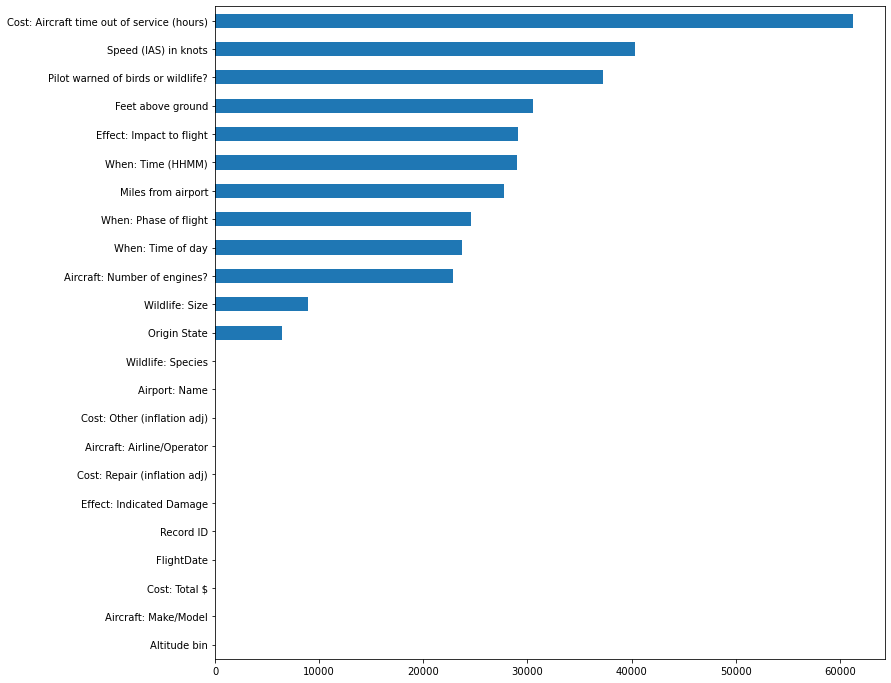

In [ ]:
data.isna().sum().sort_values().plot.barh(figsize=(12,12));

## Categorical Data

Let's look for categorical values. We can assume that categorical data has way fewer unique values than a column's total values. It's trivial to automate that assumption.

In [ ]:
#export

def findCategoricalCandidates(data:pd.DataFrame, ratio:float=0.01)->pd.DataFrame:
    result = pd.DataFrame(
        [(col, len(data[col].unique())) for col in data.columns],
        columns=['name', 'size']
    ).sort_values(by='size')
    
    n = len(data)
    return result[result['size'] / n < ratio]

For each categorical candidate, we'd like to have a tally for each possible category. This can show us problematic categories but also indicates columns that can be readily used for groupby/pivot tables. I use pd.DataFrame as a result type mainly for improved readability but also because it feels as if I was building my own database catalogue.

In [ ]:
#export

def categoricalTally(data:pd.DataFrame, cat_candidates:list, limit:int=10)->pd.DataFrame:
    result_cols = ['column'] + [f'cat{i:02d}' for i  in range(limit)]
    result = pd.DataFrame(columns=result_cols)
    
    index = 0
    for col in cat_candidates:    
        categories = data[col].unique()[:limit]
        result.loc[index] = ([col] + [(cat, len(data[data[col] == cat])) for cat in categories]
                                   + [None for i in range(len(categories), limit)])
        index += 1
        
    return result

In [ ]:
categoricalTally(data, findCategoricalCandidates(data)['name'])

,column,cat00,cat01,cat02,cat03,cat04,cat05,cat06,cat07,cat08,cat09
0,Effect: Indicated Damage,"(No damage, 61535)","(Caused damage, 4075)",None,None,None,None,None,None,None,None
1,Altitude bin,"(< 1000 ft, 27523)","(Unknown, 30541)","(> 1000 ft, 7546)",None,None,None,None,None,None,None
2,Pilot warned of birds or wildlife?,"(nan, 0)","(Y, 13100)","(N, 15261)",None,None,None,None,None,None,None
3,Wildlife: Size,"(Medium, 18064)","(Large, 3416)","(Small, 35204)","(nan, 0)",None,None,None,None,None,None
4,When: Time of day,"(nan, 0)","(Day, 25269)","(Night, 13623)","(Dusk, 1759)","(Dawn, 1207)",None,None,None,None,None
5,Effect: Impact to flight,"(nan, 0)","(None, 33247)","(Aborted Take-off, 594)","(Precautionary Landing, 1767)","(Other, 812)","(Engine Shut Down, 96)",None,None,None,None
6,Aircraft: Number of engines?,"(2, 37127)","(1, 2114)","(4, 1068)","(nan, 0)","(3, 2456)","(S, 1)",None,None,None,None
7,When: Phase of flight,"(Climb, 6317)","(Take-off run, 7239)","(Landing Roll, 7304)","(Approach, 16914)","(nan, 0)","(Taxi, 126)","(Descent, 1261)","(En Route, 1533)","(Parked, 42)","(Landing, 315)"
8,Miles from airport,"(nan, 0)","(0, 34610)","(12, 77)","(13, 13)","(20, 172)","(3, 341)","(8, 127)","(5, 394)","(50, 10)","(7, 121)"
9,Origin State,"(Michigan, 1373)","(Wisconsin, 695)","(Tennessee, 2097)","(California, 5278)","(nan, 0)","(Prince Edward Island, 97)","(Ohio, 2297)","(Florida, 3634)","(Louisiana, 1409)","(Georgia, 1083)"


## Data Repair & Cleanup

In [ ]:
data.describe()

,Record ID,When: Time (HHMM)
count,65610.000000,36636.000000
mean,246208.681116,1389.074271
std,80226.508941,613.410508
min,9005.000000,0.000000
25%,240765.250000,915.000000
50%,257226.500000,1410.000000
75%,303635.750000,1930.000000
max,322935.000000,2359.000000


Only two non-object columns is not what we expected from this dataset. Let's fix the columns that were parsed as strings but should have been numerical instead.

In [ ]:
for col in ['Speed (IAS) in knots', 'Feet above ground', 'Cost: Other (inflation adj)',
            'Cost: Aircraft time out of service (hours)', 'Cost: Other (inflation adj)',
            'Cost: Repair (inflation adj)', 'Cost: Total $']:
    data[col] = pd.to_numeric(data[col], errors='coerce')

In [ ]:
data.describe()

,Record ID,When: Time (HHMM),Cost: Aircraft time out of service (hours),Cost: Other (inflation adj),Cost: Repair (inflation adj),Cost: Total $,Feet above ground,Speed (IAS) in knots
count,65610.000000,36636.000000,4294.000000,65063.000000,64258.000000,64081.000000,26351.000000,25296.000000
mean,246208.681116,1389.074271,30.902422,2.069686,1.268745,2.786192,106.772912,144.463631
std,80226.508941,613.410508,102.120082,29.903886,26.112340,35.504005,199.300885,47.737767
min,9005.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,240765.250000,915.000000,0.000000,0.000000,0.000000,0.000000,0.000000,120.000000
50%,257226.500000,1410.000000,1.000000,0.000000,0.000000,0.000000,0.000000,140.000000
75%,303635.750000,1930.000000,10.000000,0.000000,0.000000,0.000000,100.000000,160.000000
max,322935.000000,2359.000000,984.000000,998.000000,984.000000,984.000000,995.000000,500.000000


The dataset uses its own values to fill in for missing data. It can be useful to just fold those into n/a values, so that Pandas knows how to deal with them, i.e, exlude them from groupby/crosstab.

In [ ]:
data[data['Airport: Name'] == 'UNKNOWN'] = None
data['Airport: Name'].isna().sum()

5998

We don't want the FAA's own record id to be accidentally used for correlation analysis, so we exclude the column by making it the dataset's index. Obviously, this will only work once, so we check for the index' name, in case we run this code cell again.

In [ ]:
if data.index.name != 'Record ID':
    data.set_index('Record ID', inplace=True)

data.index

Float64Index([227413.0, 226578.0, 268383.0, 229514.0, 225661.0, 230694.0,
              234288.0, 231042.0,      nan, 233011.0,
              ...
                   nan,      nan,      nan, 319982.0, 319981.0, 319591.0,
              319983.0, 319593.0, 319589.0, 319594.0],
             dtype='float64', name='Record ID', length=65610)

## Correlation

As a first approach, a correlation matrix isn't going to produce much insight, simply because categorical columns are ignored in this analysis.

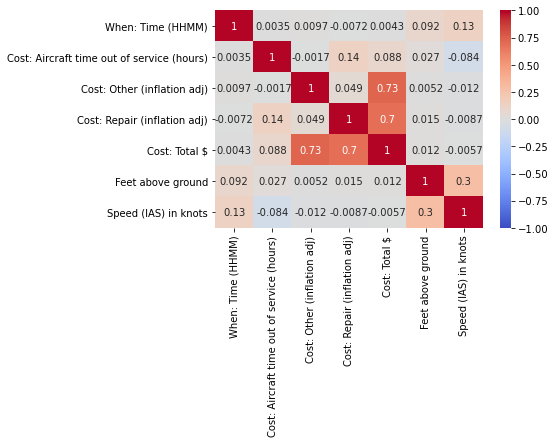

In [ ]:
sns.heatmap(data.corr(), cmap='coolwarm', annot=True, vmin=-1, vmax=1);

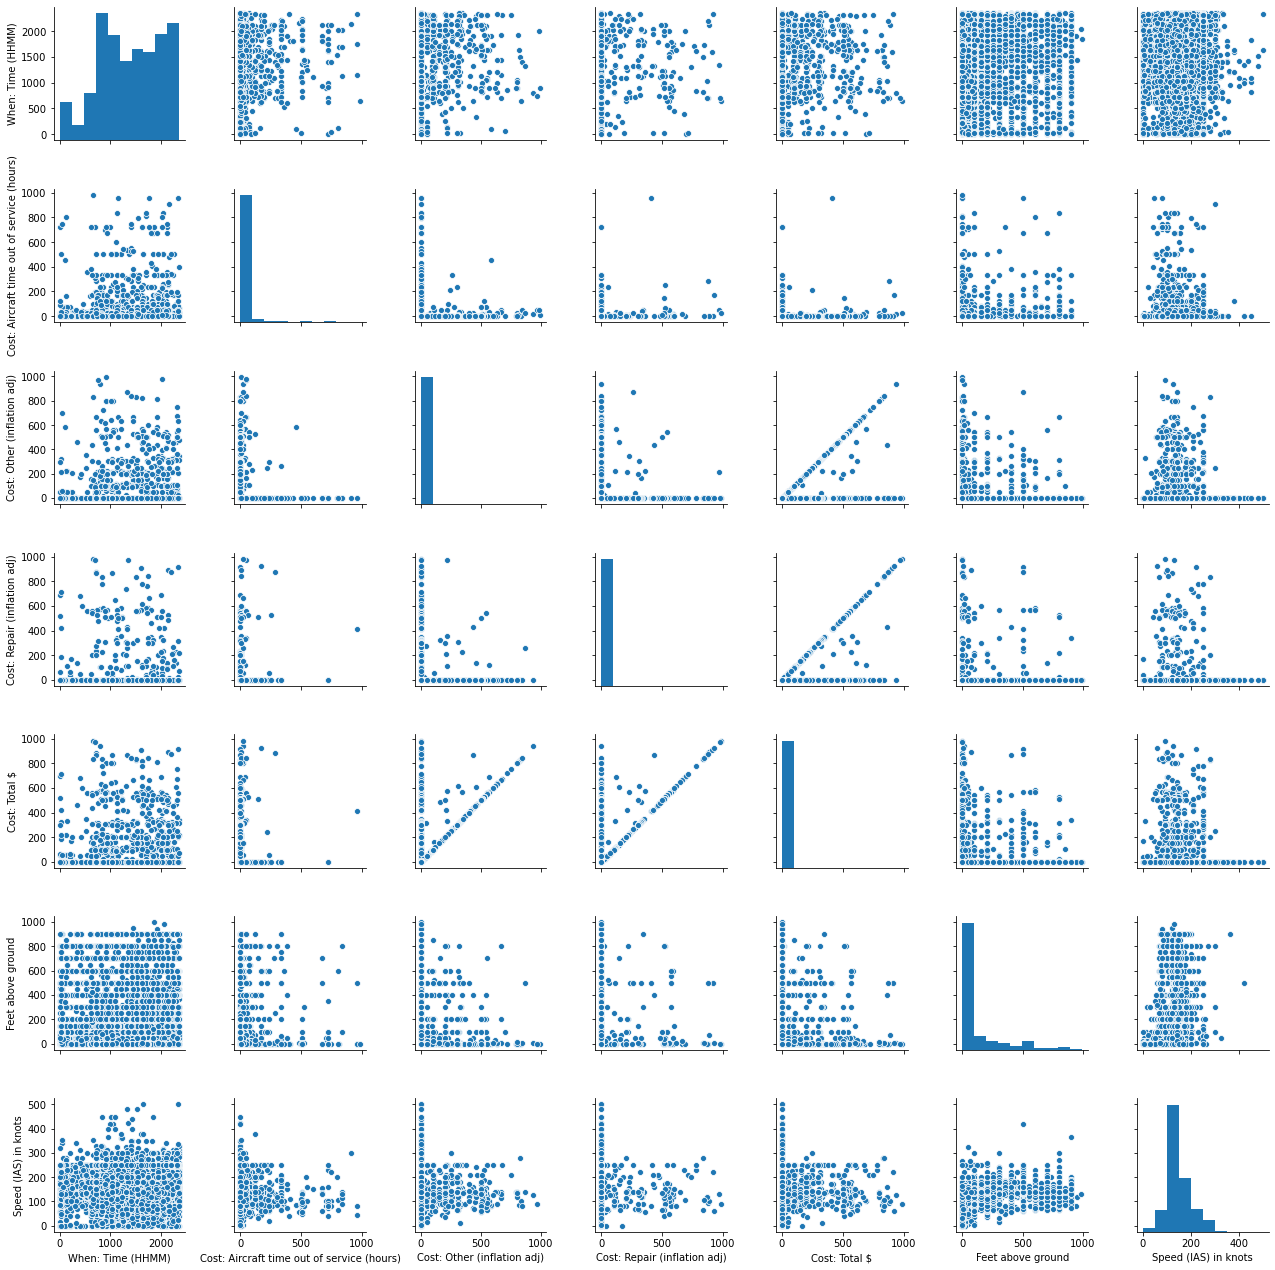

In [ ]:
sns.pairplot(data);

## Preliminary Analysis

We want to know what contributes to an increased risk of bird strikes. We have useful categorical data. Mainly we look for clustering in our data. After-the-fact data such as `Cost: Aircraft time out of service (hours)` can be safely ignored. `Effect: {Impact to flight, Indicated Damage}` can be seen as our target variables, to a degree. We can imagine multiple factors influencing the result:

* regionality: wildlife prefers some region over others,
* aircraft make/model: A Cesna is probably more affected by bird strikes than a Boeing 747,
* number of engines: Purely from a redundancy standpoint, more engines is likely to be better,
* altitude: birds fly at certain heights,
* altitude: aircraft could be more vulnerable at certain heights, with lower altitudes probably being riskier,
* time of day: wildlife has behavioural patterns,
* airline operators: some airline operators might service their aircrafts better than others, or use more reliable models,
* ...

Not all of the above mentioned factors increase the risk of a bird strike, however. In that sense, we can use the effect columns as indicators but not as final result. Also, the [FAA compiled a FAQ](https://www.faa.gov/airports/airport_safety/wildlife/faq/) that could help us understand the data. The [FAA's form to report bird strikes](https://wildlife.faa.gov/add) can give us clues as to why columns might have bad or unreliable data. 

## Data Imputation & Feature Engineering

### Time of Day
Querying by time/time of day is problematic due to the high percentage of missing data.

In [ ]:
data[['When: Time of day', 'When: Time (HHMM)']].isna().sum() / len(data)

When: Time of day    0.396037
When: Time (HHMM)    0.457186
dtype: float64

We can attempt to fix missing time of day data by using the airport's distribution of flights over the day and apply that distribution to the missing data. Not every record carries an airport name, so this won't fix all records wrt. time of day. We exploit how [pd.qcut](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html) distributes records among its categories, meaning that once we know our probabilities for a given airport, we can select one of the `When: cat` columns in our crosstable and generate a `When: Time (HHMM)` entry.

In [ ]:
#export
def timeOfDay(time_iv: pd.Interval)->str:
    if not isinstance(time_iv, pd.Interval):
        return None
    
    if (time_iv.left >= 2200 and time_iv.right < 2400) or (time_iv.left > 0 and time_iv.right < 400):
        return 'Night'
    
    if time_iv.left >= 400 and time_iv.right < 600:
        return 'Dawn'
    
    if time_iv.left >= 2000 and time_iv.right < 2200:
        return 'Dusk'
    
    return 'Day'

*The next code cell takes a while to compute, it's at least 3 nested loops, with quite a few memory allocations!*

In [ ]:
data['When: cat'] = pd.qcut(data['When: Time (HHMM)'], 24)
data_tod = data.copy()
tod_ct = pd.crosstab(data_tod['Airport: Name'], data_tod['When: cat'], margins=True)
tod_na = data_tod[data_tod['When: Time (HHMM)'].isna()]

for idx in tod_ct[:-1].index:
    row = tod_ct.loc[idx]
    total = row['All']
    prob = [i / total for i in row[:-1]]
    to_fix = tod_na.loc[tod_na['Airport: Name'] == idx]
    
    for idx_to_fix in to_fix.index:
        tod_interval = np.random.choice(tod_ct.columns[:-1], p=prob)
        mt_hours = np.random.randint(tod_interval.left, tod_interval.right) // 100 * 100
        mt_minutes = np.random.randint(tod_interval.left, tod_interval.right) % 60 # only an approximation, not the correct way to do it
        data_tod.loc[idx_to_fix, ['When: Time (HHMM)', 'When: cat', 'When: Time of day']] = (mt_hours + mt_minutes, tod_interval, timeOfDay(tod_interval))


In [ ]:
data_tod[['When: Time of day', 'When: Time (HHMM)', 'When: cat']].isna().sum() / len(data)

When: Time of day    0.109770
When: Time (HHMM)    0.094041
When: cat            0.094041
dtype: float64

### Aircraft: Make/Model &rarr; UNKNOWN

 `UNKNOWN` aircraft at `unknown` altitude can be missing data but probably also covers military aircrafts. Let's fix those `UNKNOWN` near to known military bases or mentioning a military operator to 'MIL. AIRCRAFT'. The remaining `UNKNOWN`s we can set to `None`.

In [ ]:
pred_mil_ac = (data_tod['Aircraft: Make/Model'] == 'UNKNOWN') & (
    data_tod['Aircraft: Airline/Operator'] == 'MILITARY')
pred_mil_ap = (data_tod['Aircraft: Make/Model'] == 'UNKNOWN') & (
    data_tod['Airport: Name'].isin(['DENVER INTL AIRPORT', 'DALLAS/FORT WORTH INTL ARPT']))

In [ ]:
data_tod.loc[pred_mil_ac, 'Aircraft: Make/Model'] = 'MIL. AIRCRAFT'
data_tod.loc[pred_mil_ap, 'Aircraft: Make/Model'] = 'MIL. AIRCRAFT'
data_tod.loc[data_tod['Aircraft: Make/Model'] == 'UNKNOWN', 'Aircraft: Make/Model']  = None


## Analysis & Visualization

`Effect: {Impact to flight, Indicated Damage}` are both related, yet one is missing data for nearly half the records, whereas the other is mostly complete. Instead of attempting to fix `Effect: Impact to flight` we will stick to `Effect: Indicated Damage`.

In [ ]:
data['Effect: Impact to flight'].isna().sum() / len(data), data['Effect: Indicated Damage'].isna().sum() / len(data)

(0.4969974089315653, 0.09128181679622009)

Notice that we use crosstables to get margins on each aggregated sub table. Margins show up as an additional `All` column. This simplifies sorting and makes for easier "top x"-style queries.

In [ ]:
data_ct = pd.crosstab([data['Airport: Name']], data['Effect: Indicated Damage'], margins=True)
data_ct.sort_values(by='All', ascending=False)[1:].head(5)

Effect: Indicated Damage,Caused damage,No damage,All
Airport: Name,,,
DENVER INTL AIRPORT,64,2287,2351
DALLAS/FORT WORTH INTL ARPT,47,1772,1819
MEMPHIS INTL,61,1173,1234
JOHN F KENNEDY INTL,80,1148,1228
CHICAGO O'HARE INTL ARPT,63,1061,1124


We limit our result to the first 20 records via dataframe slicing. We skip the first record because in our reversely sorted dataframe, this would show the totals for each column

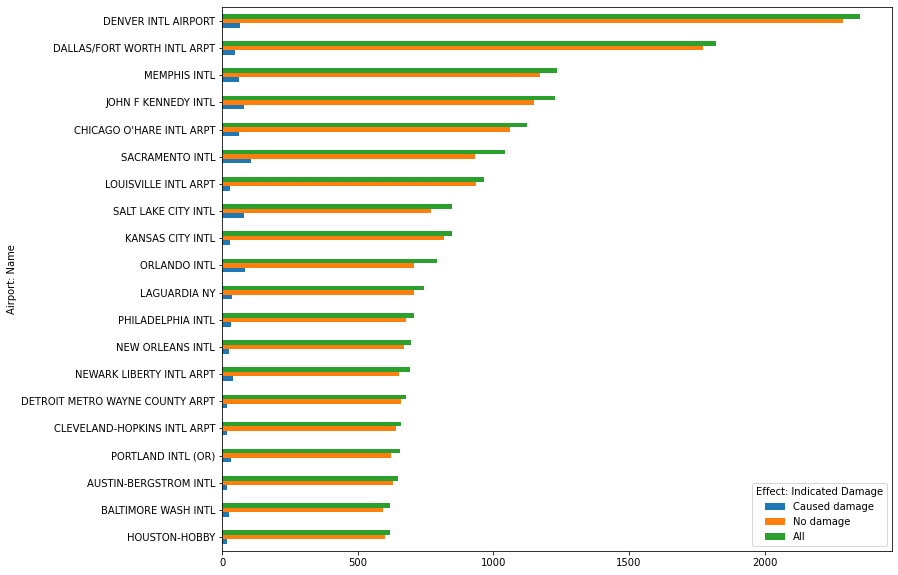

In [ ]:
data_ct.sort_values(by='All', ascending=True)[-21:-1].plot.barh(figsize=(12,10));

We can see that certain airports among the top 20, such as Denver INTL Airport or Dallas/Fort Worth INTL ARPT, report bird strikes at a much higher rate. A quick check reveals those airports to be near military (air) bases.

The majority of reported bird strikes cause no damage to the aircraft.

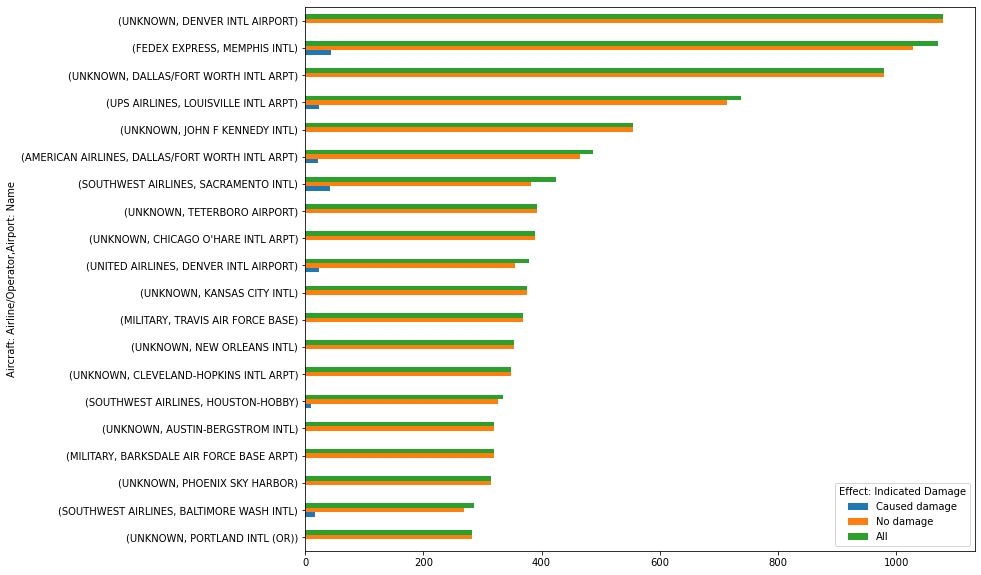

In [ ]:
data_op_ct = pd.crosstab([data['Aircraft: Airline/Operator'], data['Airport: Name']], data['Effect: Indicated Damage'], margins=True)
data_op_ct.sort_values(by='All', ascending=True)[-21:-1].plot.barh(figsize=(12,10));

Southwest Airlines shows up often, with Fedex Express at Memphis International taking the 2nd spot and UPS Airlines at Louisville INTL ARPT taking the 4th spot. Dallas/Fort Worth INTL ARPT and Denver INTL Airport are dominated by 'unknown'. The latter two are airfreight carriers, with Southwest Airlines running a [domestic airfreight branch](https://www.swacargo.com/). One can see that Fedex Express also claims the majority of bird strike reports at Memphis International (86.7%):

In [ ]:
data_op_ct.loc['FEDEX EXPRESS', 'MEMPHIS INTL']['All'] / data_ct.loc['MEMPHIS INTL']['All']

0.8679092382495948

UPS Airlines dominates bird strike reports at Louisville International Airport (76.4%):

In [ ]:
data_op_ct.loc['UPS AIRLINES', 'LOUISVILLE INTL ARPT']['All'] / data_ct.loc['LOUISVILLE INTL ARPT']['All']

0.7645228215767634

Let's check if we find other airports where bird strike reports are dominated by a single airline operator.

In [ ]:
operators = []
airports = []
ratios = []
totals = []
bounds = (.1, 1)
min_reports = 100

for idx in data_op_ct.index[:-1]:
    op = idx[0]
    ap = idx[1]
    
    t = data_ct.loc[ap]['All']
    r = data_op_ct.loc[idx]['All'] / max(1, t)

    if r >= bounds[0] and r < bounds[1] and t >= min_reports:
        operators.append(op)
        airports.append(ap)
        ratios.append(r)
        totals.append(t)

op_ap_r = pd.DataFrame({'operator': operators,
                        'airports': airports,
                        'ratio': ratios,
                        'totals': totals})

In [ ]:
op_ap_r.sort_values(by='ratio', ascending=False).head(10)

,operator,airports,ratio,totals
109,MILITARY,TRAVIS AIR FORCE BASE,0.997290,369
89,MILITARY,DOVER AIR FORCE BASE,0.994565,184
99,MILITARY,MC GUIRE AIR FORCE BASE,0.992095,253
84,MILITARY,ANDREWS AIR FORCE BASE,0.991228,114
111,MILITARY,WESTOVER ARB/METRO ARPT,0.990385,208
108,MILITARY,SHEPPARD AIR FORCE BASE,0.974359,195
100,MILITARY,MCCONNELL AIR FORCE BASE,0.971591,176
90,MILITARY,EGLIN AFB/NW FLORIDA REGIONAL ARPT,0.965753,146
104,MILITARY,NIAGARA FALLS INTL,0.876106,113
54,FEDEX EXPRESS,MEMPHIS INTL,0.867909,1234


Military bases obviously dominate bird strike reports at their respective airport, so let's filter them out.

In [ ]:
op_ap_r[op_ap_r['operator'] != 'MILITARY'].sort_values(by='ratio', ascending=False).head(10)

,operator,airports,ratio,totals
54,FEDEX EXPRESS,MEMPHIS INTL,0.867909,1234
205,UNKNOWN,GAINESVILLE REG ARPT,0.865385,104
190,UNKNOWN,CHARLES B WHEELER DOWNTOWN ARPT,0.834395,157
135,SOUTHWEST AIRLINES,DALLAS LOVE FIELD ARPT,0.826568,271
274,UNKNOWN,TWEED-NEW HAVEN ARPT,0.804878,123
0,ABX AIR,AIRBORNE AIRPARK,0.770370,135
282,UPS AIRLINES,LOUISVILLE INTL ARPT,0.764523,964
67,ISLAND AIR,KAPALUA ARPT,0.763158,114
188,UNKNOWN,BURKE LAKEFRONT,0.762215,307
275,UNKNOWN,VAN NUYS ARPT,0.723926,163


Memphis INTL and Louisville INTL ARPT look like airfreight hubs (see operators). If airfreight operations take mostly place at night, then their abnormal flight schedule could impose a higher risk of bird strikes, too.

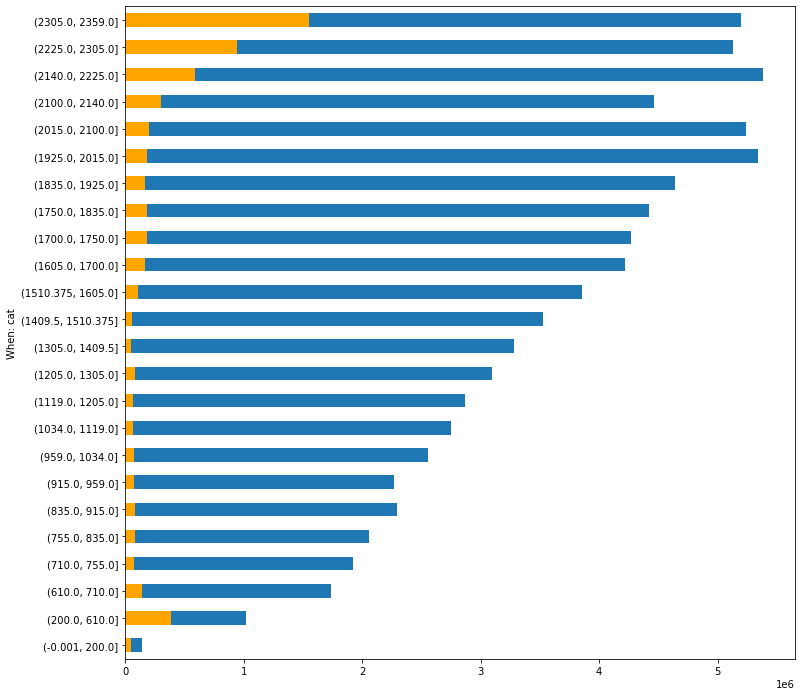

In [ ]:
airfreight_pred = data_tod['Aircraft: Airline/Operator'].isin(['FEDEX EXPRESS', 'UPS AIRLINES'])
data_tod.groupby('When: cat').sum()['When: Time (HHMM)'].plot.barh(figsize=(12,12))
data_tod[airfreight_pred].groupby('When: cat').sum()['When: Time (HHMM)'].plot.barh(color='orange');

Flying later in the afternoon or (late) in the evening increases risk of bird strikes. The time of day categories generated `by pd.qcut` are often close to one hour in range, apart from the late night/early hours categories. This indicates that flight schedules are relatively stable from noon to midnight meaning that our observation is not too dependent on flight schedules.

We can assume that airfreight carriers mostly use the nightly hours, which is why for them the risk of bird strikes is naturally higher in those hours.

## Correlations, take 2

Earlier we tried to look into correlations, but failed because too many columns were categorial. We can cast those categories into `pd.Categorical` types and then access their automagically created numeric codes so that a numerical analysis, such as `pd.DataFrame.corr()`, will produce proper results.

In [ ]:
#export
def makeCatCodes(data:pd.DataFrame, columns:list)->pd.DataFrame:
    for col in columns:
        data[col] = pd.Categorical(data[col])

    codes = {}
    for col in columns:
        codes[col] = data[col].cat.codes
        
    return pd.DataFrame(codes)

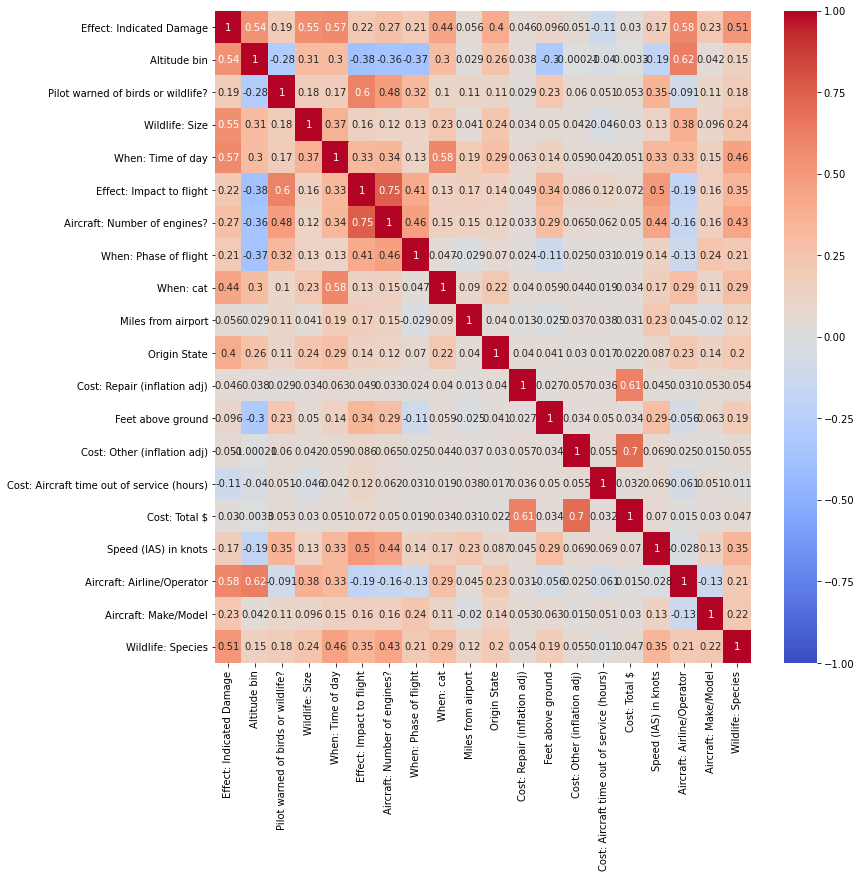

In [ ]:
data_cc = makeCatCodes(data_tod, findCategoricalCandidates(data_tod.copy())['name'])
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(data_cc.corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True, ax=ax);

Several clusters can be identified directly:
* `{'Effect: Indicated Damage', 'Altitude bin', 'Wildlife: Size'}²`
* `{'Aircraft: Airline/Operator', 'Aircraft: Make/Model', 'Wildlife: Species'} x {'Effect: Indicated Damage', 'Altitude bin', 'Wildlife: Size'}`
* `{'When: Time of day', 'Effect: Impact to flight', 'Aircraft: Number of engines?'}²`
* `{'When: Time of day', 'Effect: Impact to flight', 'Aircraft: Number of engines?'} x {'Speed (IAS) in knots', 'Aircraft: Make/Model', 'Wildlife: Species}`

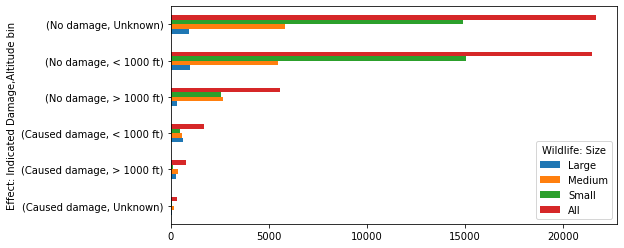

In [ ]:
pd.crosstab([data_tod['Effect: Indicated Damage'], data_tod['Altitude bin']],
            data_tod['Wildlife: Size'], margins=True).sort_values(by='All', ascending=True)[:-1].plot.barh(figsize=(8, 4));

Bird strikes seem to happen with much higher frequency at lower altitudes.

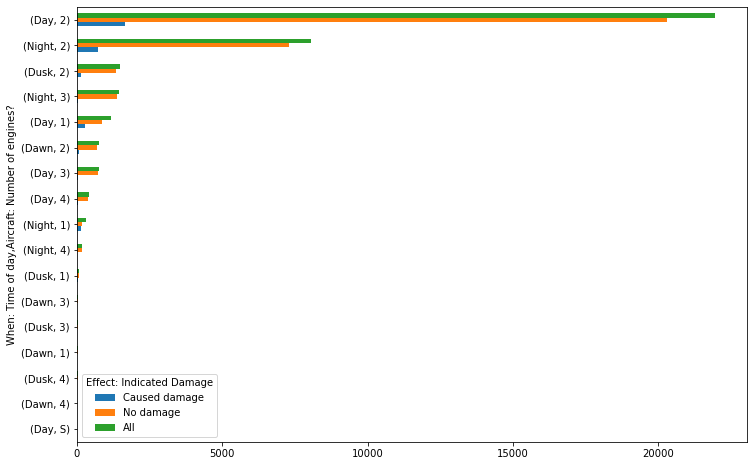

In [ ]:
pd.crosstab([data_tod['When: Time of day'], data_tod['Aircraft: Number of engines?']], data_tod['Effect: Indicated Damage'],
            margins=True).sort_values(by='All', ascending=True)[:-1].plot.barh(figsize=(12, 8));

What shows up as strong correlation might just be a result of frequency wrt. twin-engine aircrafts flying during the day (read: almost all commercial airlines or modern military jets).

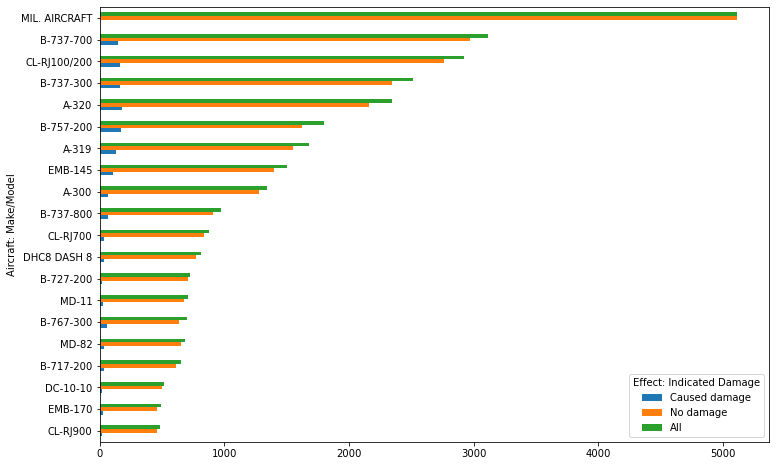

In [ ]:
pd.crosstab(data_tod['Aircraft: Make/Model'], data_tod['Effect: Indicated Damage'],
            margins=True).sort_values(by='All', ascending=True)[-21:-1].plot.barh(figsize=(12, 8));

Aircraft models favored by (commercial) operators fly more often and therefore report more bird strikes, naturally. Military aircrafts report the majority of bird strikes.

It's difficult to see whether the size of an aircraft, such as the massive Boeing 737 variants as compared to a much smaller model such as the DHC8 DASH 8, has an effect. Type of engine, such as turboprop vs jet engines, which is a distinctive feature among aircraft models, could also influence this figure.

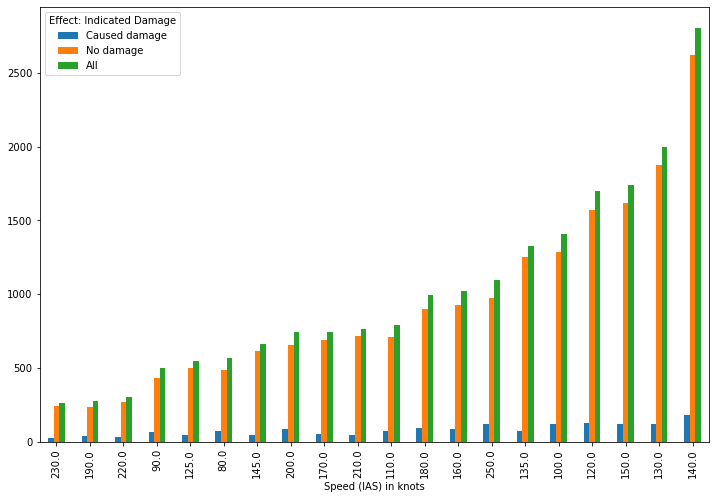

In [ ]:
pd.crosstab(data_tod['Speed (IAS) in knots'], data_tod['Effect: Indicated Damage'],
            margins=True).sort_values(by='All', ascending=True)[-21:-1].plot.bar(figsize=(12, 8));

There is a speed interval around 100-180 knots that reports the majority of bird strike reports.

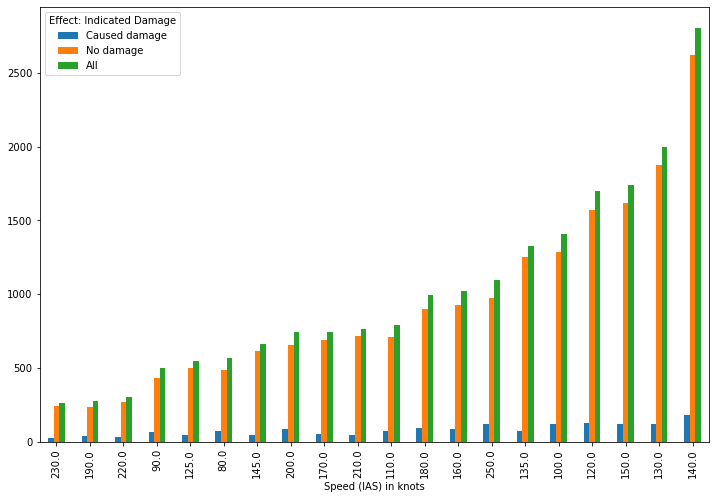

In [ ]:
pd.crosstab(data_tod['Speed (IAS) in knots'], data_tod['Effect: Indicated Damage'],
            margins=True).sort_values(by='All', ascending=True)[-21:-1].plot.bar(figsize=(12, 8));

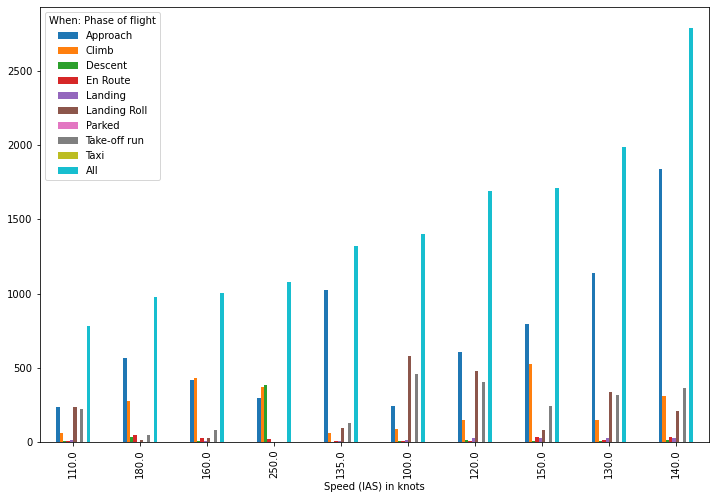

In [ ]:
pd.crosstab(data_tod['Speed (IAS) in knots'], data_tod['When: Phase of flight'],
            margins=True).sort_values(by='All', ascending=True)[-11:-1].plot.bar(figsize=(12, 8));

Most bird strike seemingly happen during approach, with a speed (IAS) between 120 and 140 knots.
Climb phase (at slightly higher speeds) and descent (at approx. twice the speed) also show an increase in bird strike reports.

## Summary